# ELEC 221 Assignment 6: radio 

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample
from IPython.display import Audio, Image
from IPython.core.display import HTML

In this problem, you'll implement a simulated AM radio system that is a little more realistic in terms of the operation of the receiver and demodulation process. 

Suppose you and your colleague have been put in charge of a radio broadcast company that manages 5 stations at the following frequencies (in kHz): 580, 600, 620, 640, and 660. Note that typically, AM is used for talk radio, which requires a bandwidth of ~10 kHz. However to make things interesting, we're going to use music which requires a wider range.

**Question 0.1 (1 point)**. To make things more meaningful for you (hopefully!), choose five audio_data, perhaps of different genres, for your radio stations. Select ~4-5s clips of each, and use a sampling rate of somewhere between 40000-48000.

In [162]:
# Prepare some samples and load them in here.
# wav = wavfile.read("my_song.wav") 

# The result of importing a wavfile should be a tuple of two elements:
# the sample rate, and the audio signal, which may be have multiple wav_data.
# sample_rate = wav[0]

# My audio sample had multiple wav_data. Yours may not.
# In my case, I took just one of these wav_data, and converted it from 
# integer values to floats.
# channel_0 = wav[1][:, 0]
# song_1 = np.array(channel_0, dtype=np.float64) / np.max(channel_0)

In [178]:
## Upsample by zero insertion, adding n-1 zeros between elements
def upsample(signal: np.ndarray, n: int):
    # Edge case
    if n == 1 or n == 0:
        return signal
    
    N = len(signal)
    out = np.zeros(N*n)
    
    for i in range(0,N):
        out[n*i] = signal[i]
    return out

def downsample(signal: np.ndarray, n: int):
    # Edge case
    if n == 1 or n == 0:
        return signal
    
    N = (int)(len(signal)/n)
    out = np.zeros(N)
    
    for i in range(0,N):
        out[i] = signal[n*i]
    return out
    
def bandpassFilter(signal: np.ndarray, center_freq: int, bandwidth: int, sample_r):
    spectrum = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/sample_r)
    out = [0 if(np.abs(frequencies[index] - center_freq) > bandwidth) else spectrum[index] for index in range(len(spectrum))]
    return np.fft.ifft(out)


In [164]:
wav_files = [
    wavfile.read("flashingLights.wav"),
    wavfile.read("favorite.wav"),
    wavfile.read("newYork.wav"),
    wavfile.read("photograph.wav"),
    wavfile.read("redroom.wav")
]

# Get float arrays of audio data
wav_data = [ wav[1][:,0] for wav in wav_files ]
audio_data = [ np.array(channel, dtype=np.float64) / np.max(channel) for channel in wav_data]

file_lengths = [ len(channel) for channel in wav_data]
sample_rates = [ wav[0] for wav in wav_files ]
sample_rate = 48000 # Use 48000 as sample rate for all songs

# Shorten files to the length of the smallest audio sample
min_file_length = np.min(file_lengths)
for i in range(len(audio_data)):
    if len(audio_data[i]) > min_file_length:
        audio_data[i] = audio_data[i][:min_file_length]


C:\Users\laura\AppData\Local\Temp\ipykernel_27536\3703257458.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read("flashingLights.wav"),
C:\Users\laura\AppData\Local\Temp\ipykernel_27536\3703257458.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read("favorite.wav"),
C:\Users\laura\AppData\Local\Temp\ipykernel_27536\3703257458.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read("newYork.wav"),
C:\Users\laura\AppData\Local\Temp\ipykernel_27536\3703257458.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read("photograph.wav"),
C:\Users\laura\AppData\Local\Temp\ipykernel_27536\3703257458.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  wavfile.read("redroom.wav")


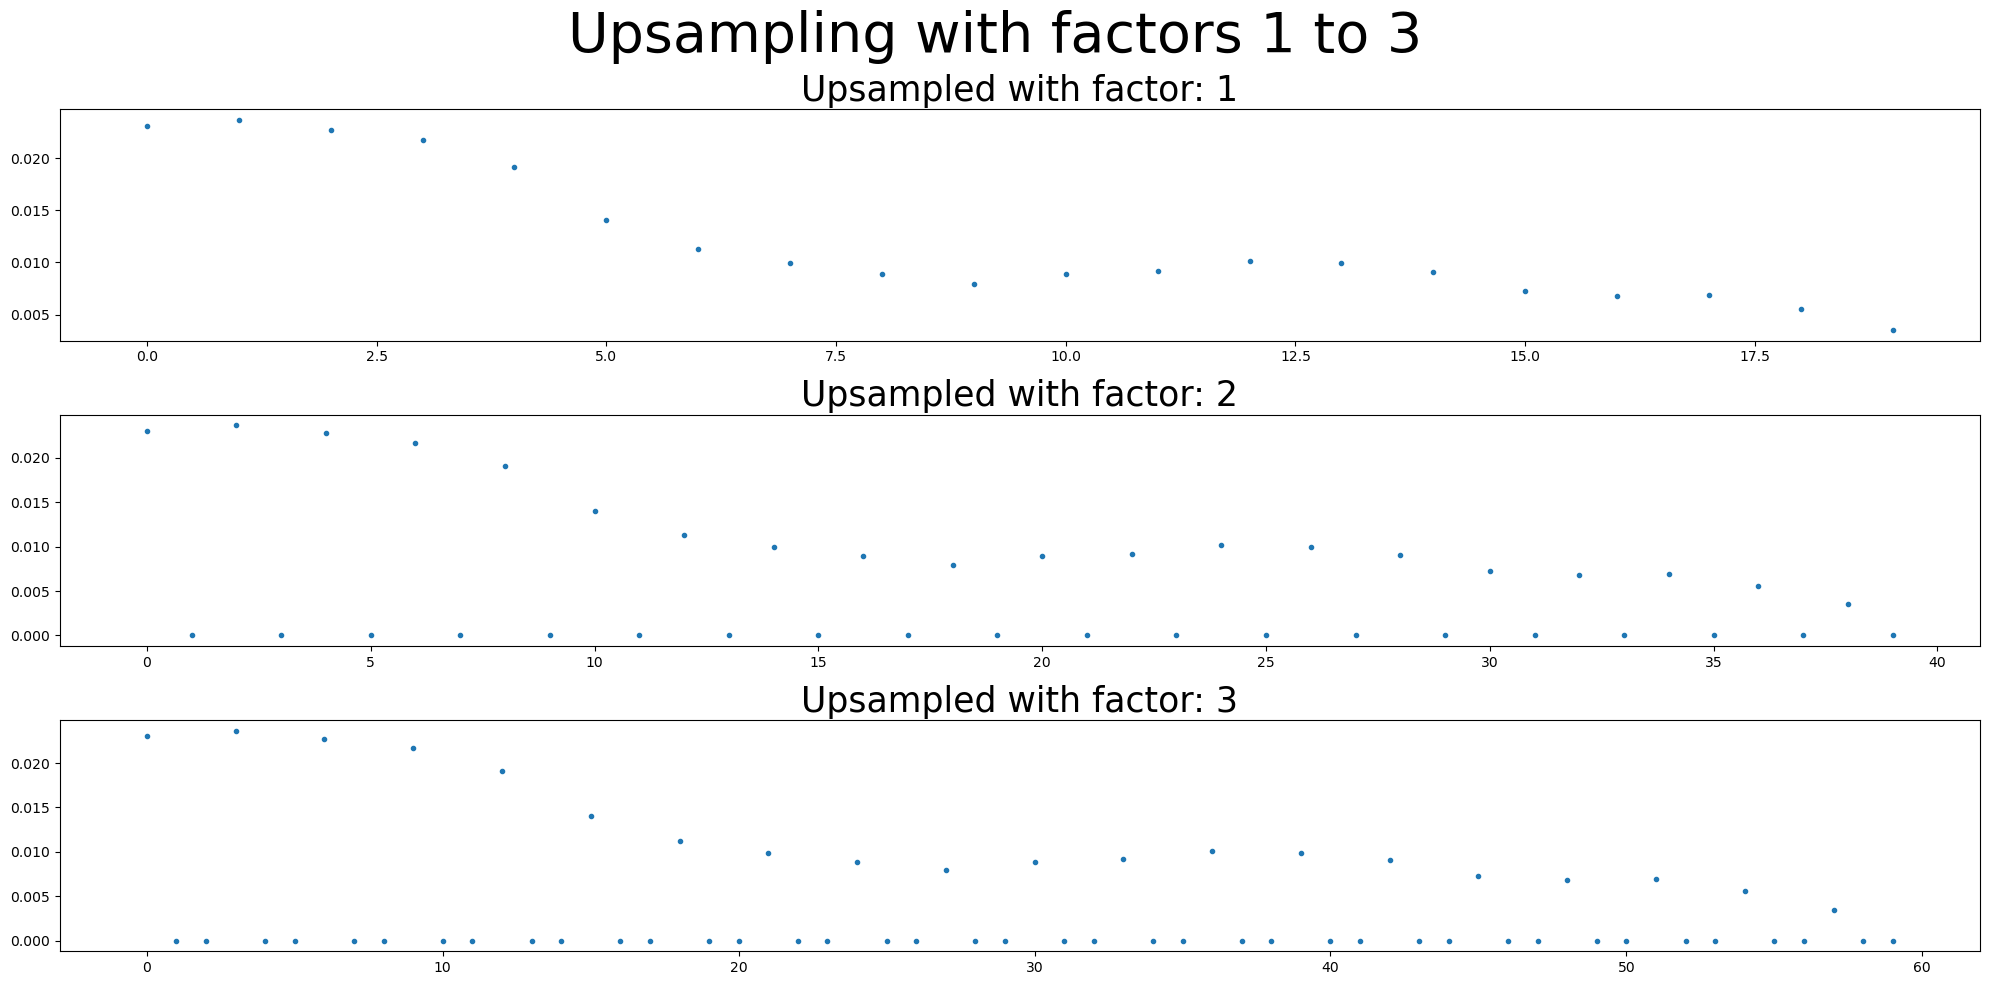

In [165]:
M = 3
fig,axs = plt.subplots(3, figsize=(20,10))
fig.suptitle("Upsampling with factors 1 to 3", fontsize=40)
for m in range(0,M):
    axs[m].plot(upsample(audio_data[2],m+1)[:20*(m+1)], '.')
    axs[m].set_title(f"Upsampled with factor: {m+1}", fontsize=25)
fig.tight_layout()

## Part 1. The broadcast

We will begin by setting up the broadcast process according to the following block diagram:

<img src="broadcast.png" width=700>

We'll do this in a couple different steps.

**Question 1.1 (1 point)**. First, design a lowpass filter to reduce the bandwidth of a signal to within the acceptable range of our radio stations.

In [166]:
def reduce_signal_bandwidth(signal):
    """Reduce the bandwidth of a signal to within a ~20 kHz band.
    
    Here, 20 kHz corresponds to the space a signal will take when considering
    both positive and negative frequencies, like we have seen during the 
    amplitude modulation lectures in class. 
    
    It is up to you to decide how to filter it. You may choose to use an 
    ideal brick wall filter, or a more realistic non-ideal filter (it doesn't
    need to be exactly 20 kHz wide, just something appropriate for the
    application).
    
    Args:
        signal (array[float]): A real-valued signal.
        
    Returns:
        array[float]: A signal that has been filtered so that its spectrum is 
        band-limited. 
    """
    frequencies = np.fft.fftfreq(len(signal), 1/sample_rate)
    fourier_spectrum = np.fft.fft(signal)
    modified_spectrum = np.array([0 if(np.abs(frequencies[index]) > 10) else fourier_spectrum[index] for index in range(len(fourier_spectrum))])
    return np.fft.ifft(modified_spectrum)
    

**Question 1.2 (1 point)** Implement a function that performs sinusoidal amplitude modulation (with a $\cos$ carrier signal) of a signal into the frequency range of a desired radio station.

In [167]:
def sinusoidal_amplitude_modulation(signal, station_frequency, phase=0.0, sample_r=48000):
    """Modulate a signal up to the frequency of a desired AM radio station.
    
    The amplitude modulation should have the form:
       y(t) = x(t) * c(t) = x(t) * cos(2 * π * f_c * t + θ_c) 
    where f_c is the carrier (station) frequency, and θ_c is a phase.
    
    Args:
        signal (array[float]): A real-valued signal.
        station_frequency (int): The (carrier) frequency of the station, in kHz.
        phase (float): The phase of the carrier signal. 
        
    Returns:
        array[float]: The modulated signal.
    """
    omega = 2*np.pi*station_frequency/(sample_r)
    modulated_signal = [signal[time]*np.cos(omega*time + phase) for time in range(len(signal))]
    return modulated_signal
    

**Question 1.3 (1 point)**. Your radio company will use frequency-division multiplexing (FDM) to send multiple signals over the same channel. Using the frequencies listed above, implement a broadcast (transmission) system that takes a set of signals as input, and outputs the full radio broadcast.

In [171]:
def broadcast(signals):
  
    """Broadcast a set of signals at different frequencies to simulate 
    a set of radio stations.
    
    This function should:
      - reduce the bandwidth of each of the provided signals
      - modulate each one to the correct frequency range
      - perform FDM to generate a combined output signal to be broadcast
    
    Args:
        signals (list[array[float]]): A list of signals to be transmitted. 
             Assume that they are provided in order of increasing station frequency.
    
    Returns:
        array[float]: A single channel contain the frequency-division multiplexed
        set of signals.
    """
    stations = [580000, 600000, 620000, 640000, 660000]#Hz
    highestradiofreq = 700000 #rounded up to be safe
    numUpsamples = (int)(2*highestradiofreq/sample_rate) #number of upsamples, found using the neiquist sampling thm
  
    out = np.zeros(numUpsamples*len(signals[0]))
    for index in range(len(signals)):
    
      out += sinusoidal_amplitude_modulation(resample(signals[index], numUpsamples*len(signals[index])),  stations[index], sample_r = numUpsamples*sample_rate)  # Output signal

    return out


## Part 2. A simple receiver

In order to test your broadcasting setup, let's implement a simple synchronous demodulation system.

**Question 2.1 (1 point)** Complete the function below to implement the synchronous demodulation system that we described in class (see the docstring below for details). 

In [181]:
def simple_receiver(broadcast, station_frequency, phase=0.0, bandpass=True):
    """Demodulate the radio broadcast and extract a desired station.
    
    This function should:
      - apply a bandpass filter (if specified) to the signal to extract
        only the parts of the spectrum in the desired station's frequency range
      - demodulate with a sinusoidal carrier (use cos) at the desired frequency
      - apply a low-pass filter with the appropriate gain to recover the signal
    
    Args:
        broadcast (array[float]): A radio broadcast consisting of five wav_data
            that have been FD multiplexed.
        station_frequency (int): The frequency (in kHz) of the radio station.
        phase (float): The phase of the demodulating signal.
        bandpass (bool): Whether or not to apply a bandpass filter before
            demodulating and filtering.
    
    Returns:
        array[float]: The signal of the radio station at the desired frequency.
    """
    
    max_radio_freq = 700000 #rounded up to be safe
    num_down_samples = (int)(2*max_radio_freq/sample_rate)
    bandwidth = 10000
    if bandpass:
      out = bandpassFilter(broadcast, station_frequency, bandwidth, num_down_samples*sample_rate)
    
    out = sinusoidal_amplitude_modulation(out, station_frequency, phase, num_down_samples*sample_rate)
    out = reduce_signal_bandwidth(out)
    out = resample(out, (int)(len(out)/num_down_samples))
  
    return out

**Question 2.2 (0.5 point)**. Test your demodulation function below to extract the 600 kHz station.

In [173]:
broadcast_array = broadcast(audio_data)

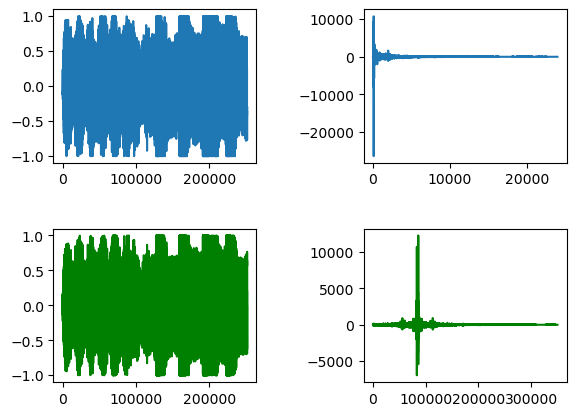

In [141]:
fig, axs = plt.subplots(2,2)
fdm_out = sinusoidal_amplitude_modulation(audio_data[0], 5800)
axs[0,0].plot(audio_data[0])
axs[0,1].plot(np.fft.rfftfreq(len(audio_data[1]), 1/sample_rate), np.fft.rfft(audio_data[0]))
axs[1,0].plot(fdm_out, 'g')
axs[1,1].plot(np.fft.rfftfreq(len(fdm_out), 1/700_000), np.fft.rfft(fdm_out), 'g')

fig.tight_layout(pad=3.0)

In [108]:
recieved_array = simple_receiver(broadcast_array, 600000, 0.0, True)


In [110]:
print(len(recieved_array))
print(len(audio_data[1]))
print(broadcast_array)
display(Audio(audio_data[1], rate=sample_rate))
Audio(recieved_array, rate=sample_rate)

250086
251524
[-0.03874519 -0.02789253 -0.01801082 ... -0.07672157 -0.06320807
 -0.05053169]
[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


c:\Users\laura\anaconda3\lib\site-packages\IPython\lib\display.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
c:\Users\laura\anaconda3\lib\site-packages\IPython\lib\display.py:174: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


**Question 2.3 (0.5 point)**. Test your demodulation function with a non-zero phase; what happens to the output signal when the modulation and demodulation are not perfectly in sync?

**Question 2.4 (0.5 point)**. Set `bandpass=False` and test the demodulation; how does it sound?

**Question 2.5 (0.5 point)**. Try demodulating with an invalid station frequency (e.g., 590, 610, anything that sits in between our allotted values). Does this sound like you expect?

## Part 3: the superheterodyne receiver

In practice, AM radio is demultiplexed and demodulated by a system called the [superheterodyne receiver](https://en.wikipedia.org/wiki/Superheterodyne_receiver) (or superhet for short). Consider the (simplified) diagram below (there should in principle be some amplifiers in here, but we will ignore them):

<img src="superhet.png" width="800">

Here, $y(t)$ corresponds to the multiplexed signal that your broadcast outputs. This is put through a coarse tunable bandpass filter (this corresponds to you turning the radio dial), then mixed with a variable-frequency local oscillator to produce a signal centered at an intermediate frequency (IF) of 455 kHz. Said signal is then put through a fixed bandpass filter before being sent to the demodulator.

**Question 3.0 (0.5 point)**: Why do you think this kind of setup is used; why not just use a simple tunable filter from the get go? (You may need to do a little research on the history of the development of radio.)

**Question 3.1 (1 point)**: Implement the heterodyning process in the the graphic above. The function should take the multiplexed signal as input and a desired radio station frequency, and output the demodulated audio signal.

In [29]:
def superhet_receiver(radio_broadcast, station_frequency):
    """Implement a simplified superheterodyne receiver to extract a desired station.
    
    This function should:
      - apply a bandpass filter to the signal to extract the correct 
        frequency regime 
      - use a local oscillator (frequency related to the bandpass) to yield an
        intermediate frequency signal at 455 kHz
      - apply a fixed bandpass filter and then demodulate to recover the station
    
    Args:
        broadcast (array[float]): A radio broadcast consisting of five wav_data
            that have been FD multiplexed.
        station_frequency (int): The frequency (in kHz) of the radio station.
    
    Returns:
        array[float]: The signal of the radio station at the desired frequency.
    """
    return

**Question 3.2 (0.5 point)**: Let's put everything together: below, use the broadcast function to create a signal, and then pass it to the superheterodyne receiver to play your favourite station. 